<a href="https://colab.research.google.com/github/tensorflow-project/FineTuning/blob/main/Experiments/CosineSimilarity4emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tensorflow-project/FineTuning

Cloning into 'FineTuning'...
remote: Enumerating objects: 1872, done.
remote: Counting objects: 100% (835/835), done.
remote: Compressing objects: 100% (354/354), done.
remote: Total 1872 (delta 615), reused 655 (delta 476), pack-reused 1037
Receiving objects: 100% (1872/1872), 119.85 MiB | 17.70 MiB/s, done.
Resolving deltas: 100% (1334/1334), done.


In [2]:
import sys
import os
from google.colab import drive
import numpy as np
import keras
import tensorflow as tf
import urllib.request
import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

### agree to mounting your Google Drive for saving the new weights later on
drive.mount("/content/drive")

py_file_location = "/content/FineTuning/four_emotions"
sys.path.append(os.path.abspath(py_file_location))
py_file_location = "/content/FineTuning/models"
sys.path.append(os.path.abspath(py_file_location))

import textual_inversion_four_emotions as txt

Mounted at /content/drive
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
### create an instance of the StableDiffusion() class
stable_diffusion = txt.StableDiffusion()

### our new concept which is later inserted in the different prompts (for training and image generation).
###The goal is to create an embedding for our placeholder_token
placeholder_token = ""


### Add our placeholder_token to our stable_diffusion Model
stable_diffusion.tokenizer.add_tokens(placeholder_token)

train_ds = txt.create_dataset(stable_diffusion, placeholder_token)

### beta is the diffusion rate 
noise_scheduler = txt.NoiseScheduler(
    ### beta_start determines the amount of noise added at the start of the denoising process
    beta_start=0.00085,
    ### beta_end at the end of the denoising process
    beta_end=0.012,
    ### the beta_schedule determines that the diffusion rate increases linearly
    beta_schedule="scaled_linear",
    train_timesteps=1000,
)

training_image_encoder = keras.Model(
        stable_diffusion.image_encoder.input,
        stable_diffusion.image_encoder.layers[-2].output,
    )
    
    
#EPOCHS = 50
### learning rate decays depending on the number of epochs to avoid convergence issues in few epochs 
### in the originial tutorial a scheduler is used but we experienced to have better results without a scheduler
"""learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, decay_steps=train_ds.cardinality() * EPOCHS
)"""
### inizialize the optimizer
optimizer = tf.keras.optimizers.Adam(
    weight_decay=0.004, learning_rate=1e-4, epsilon=1e-8, global_clipnorm=10
)

txt.textual_preprocessing(stable_diffusion, placeholder_token)

### embeddings for cosine similarity
sticker_embedding = []
cosine_similarity = []
cosine_similarity.append(txt.cosine_sim(txt.get_embedding("broccoli", stable_diffusion), txt.get_embedding(placeholder_token, stable_diffusion)))

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
202761/202761 [==============================] - 0s 2us/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


198180272/198180272 [==============================] - 2s 0us/step


/content/FineTuning/four_emotions/textual_inversion_four_emotions.py:536: RuntimeWarning: invalid value encountered in float_scalars
  sim = dot(e1, e2)/(norm(e1)*norm(e2))


Epoch 1/2: 100%|██████████| 535/535 [02:51<00:00,  3.12it/s]


31/31 [==============================] - 14s 168ms/step


Epoch 2/2: 100%|██████████| 535/535 [01:46<00:00,  5.00it/s]


31/31 [==============================] - 5s 166ms/step


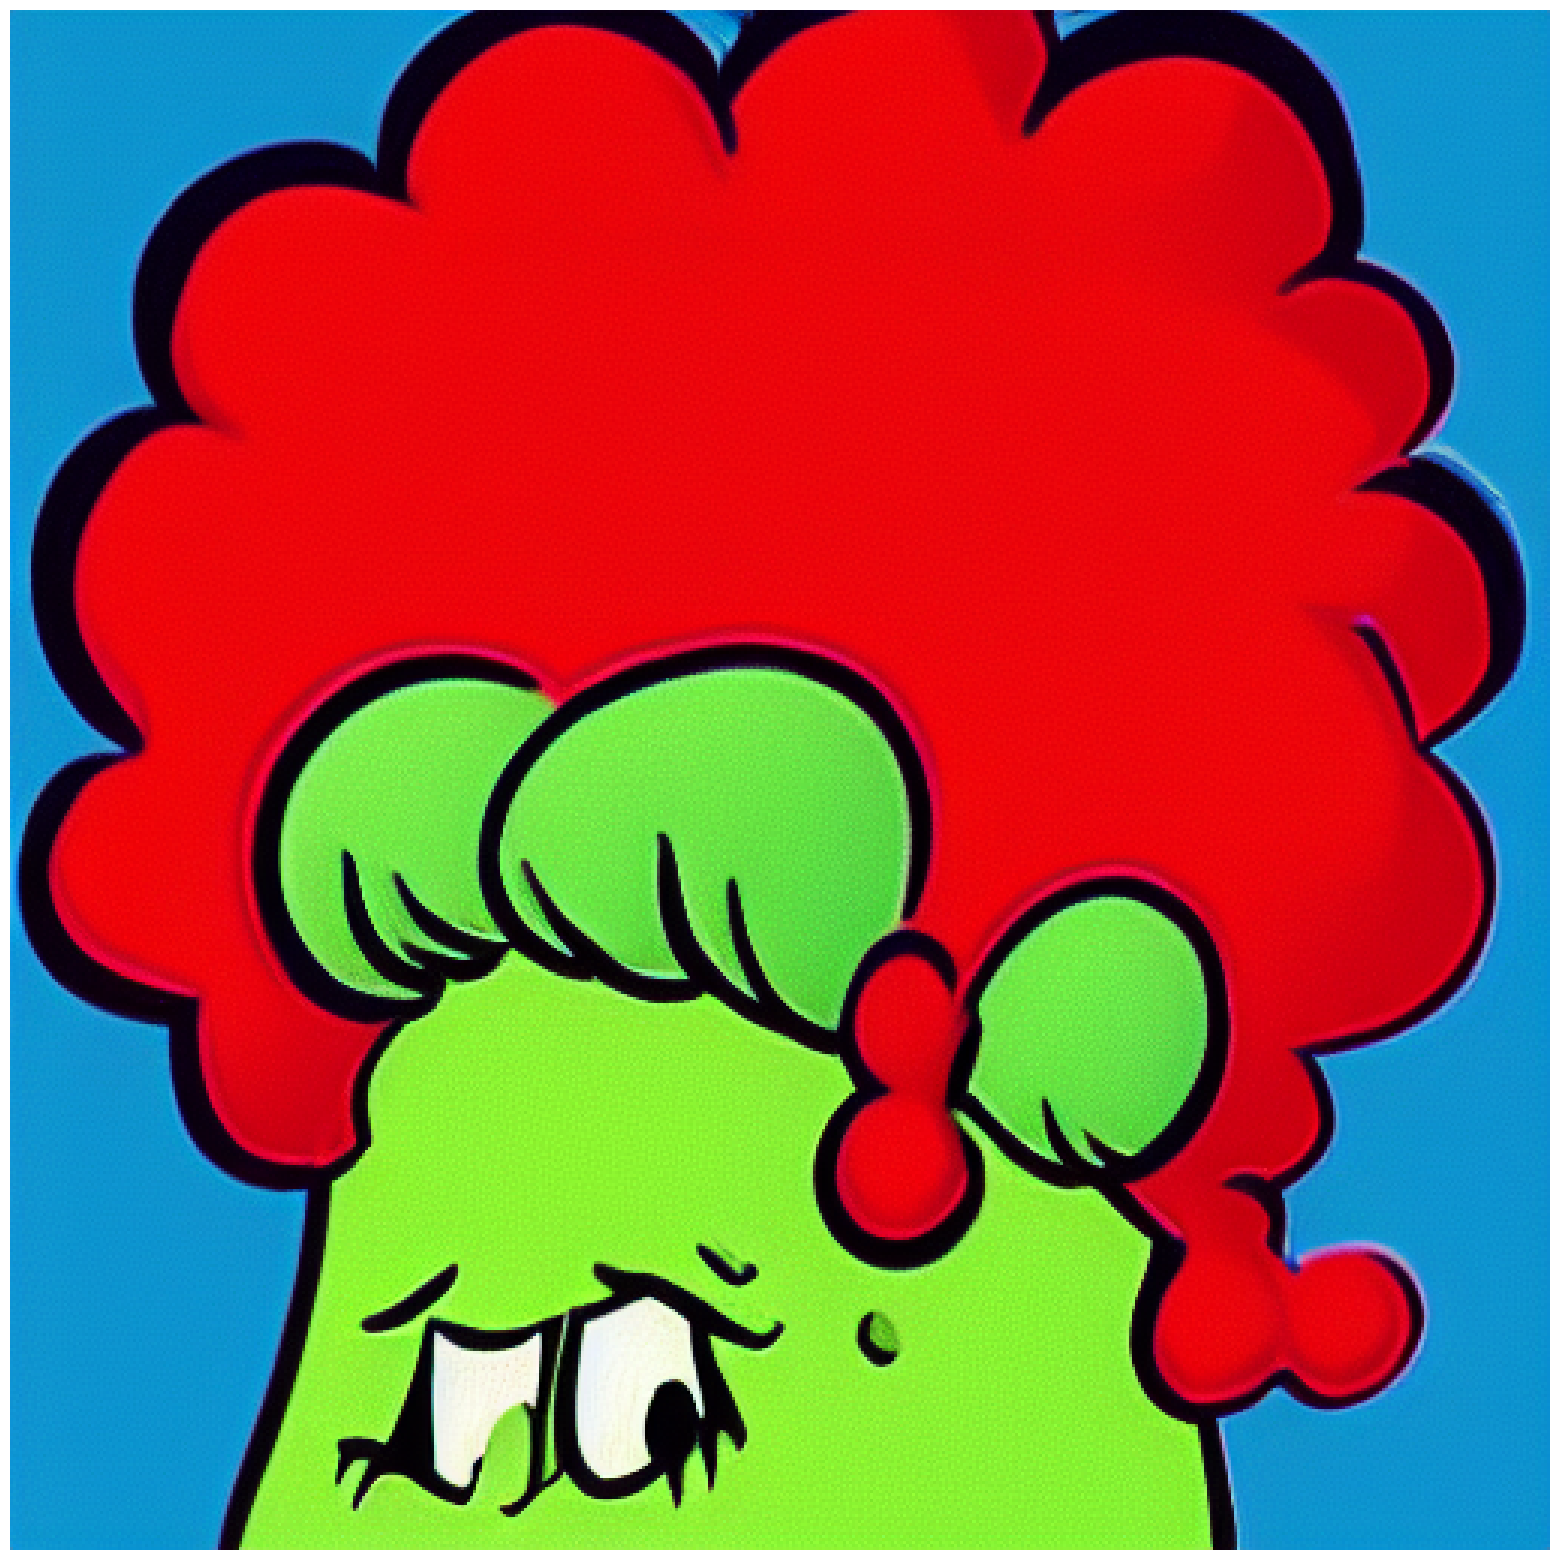

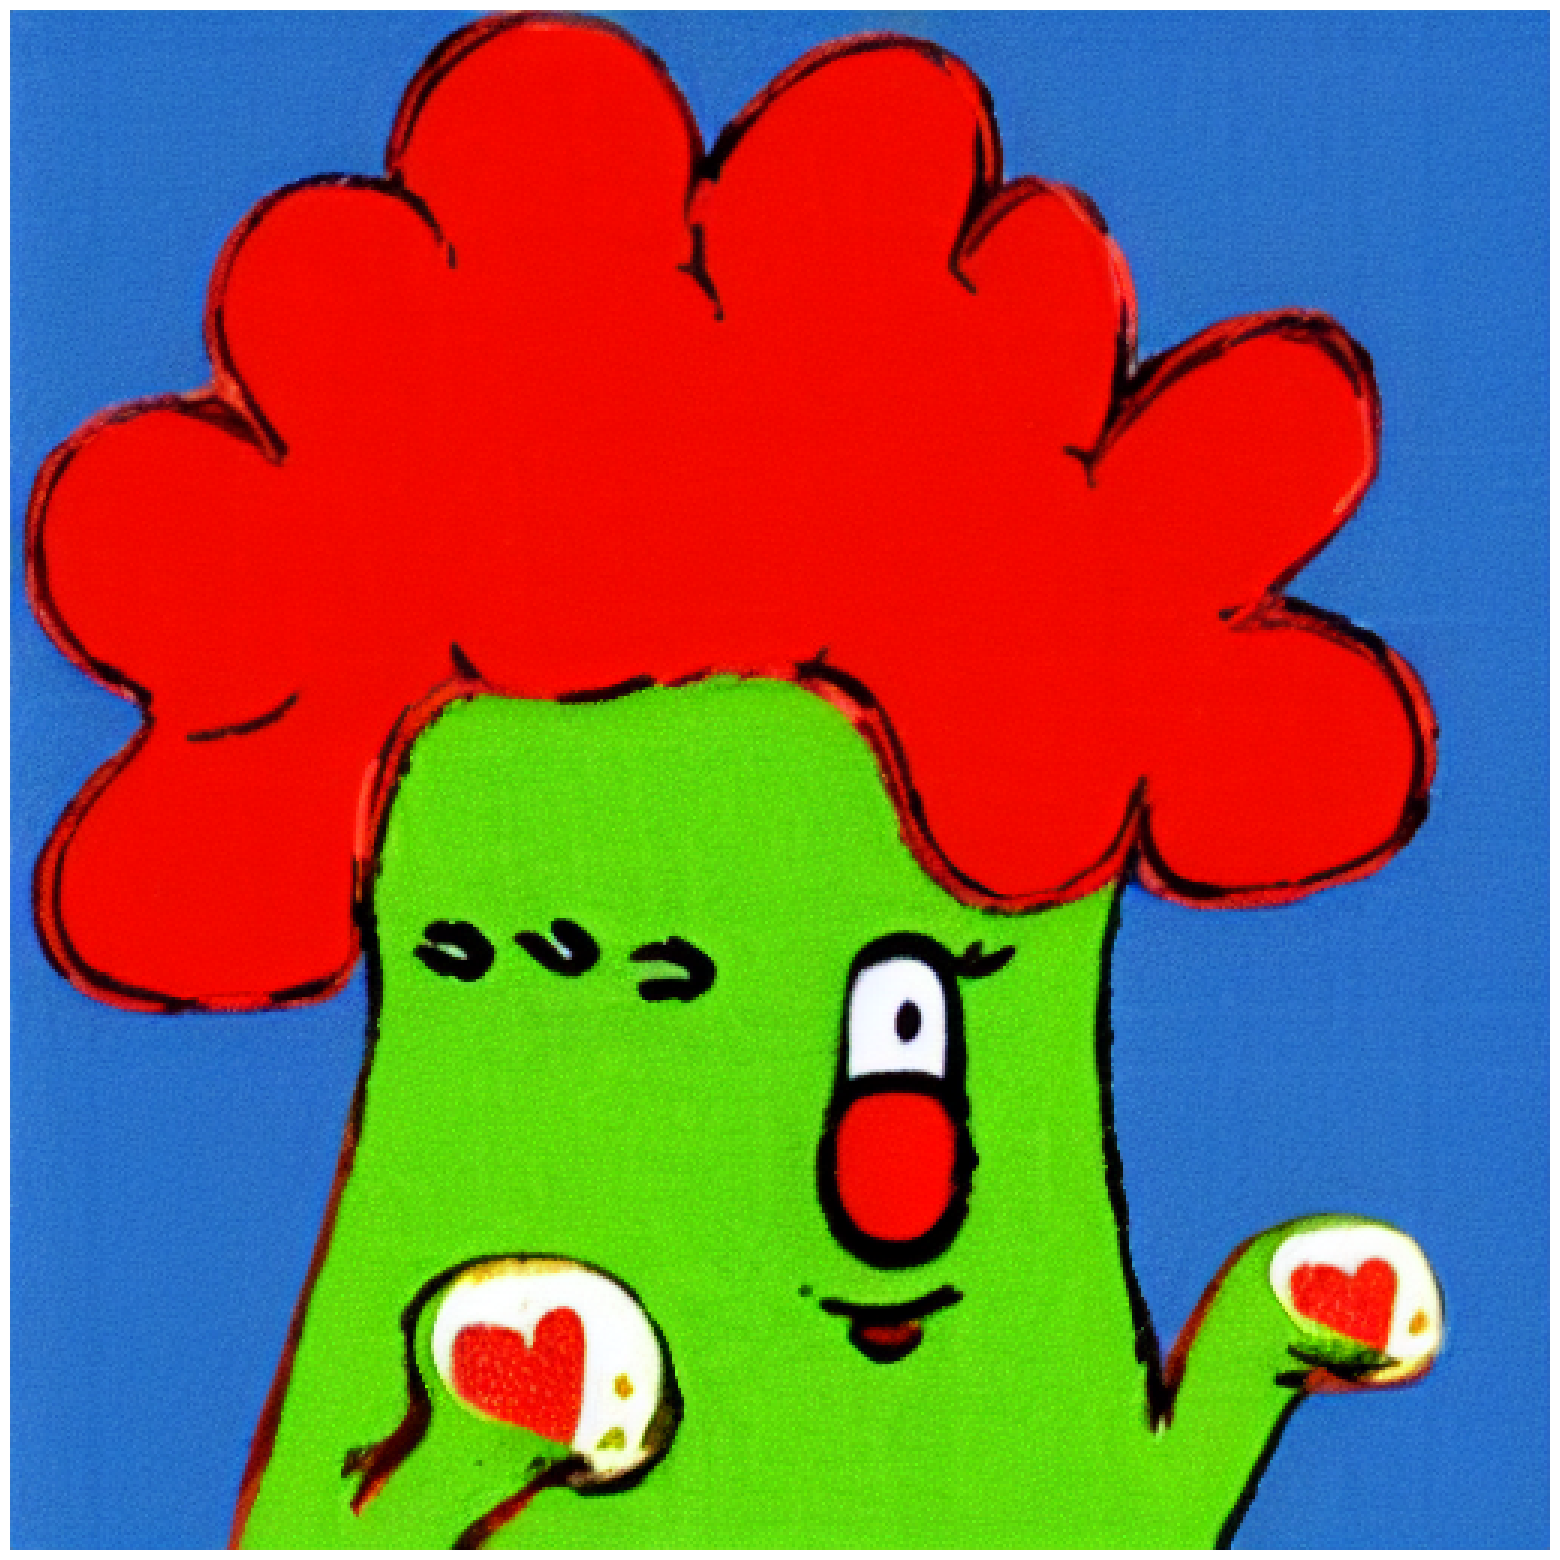

In [4]:
### how long to train for
epochs = 2
epoch_num = list(range(epochs+1))
txt.training(epochs, stable_diffusion, train_ds, sticker_embedding, cosine_similarity, stable_diffusion, noise_scheduler, training_image_encoder, optimizer, placeholder_token)

In [5]:
### where to store your newly generated weights
path = '/content/drive/MyDrive/weights_four_emotions.npy'

In [6]:
### get the weights of the text encoder and save the to Google Drive
text_encoder_weights = np.array(stable_diffusion.text_encoder.get_weights(), dtype=object)

### save the weights array to a file on your Google Drive
np.save(path, text_encoder_weights)

In [7]:
path = '/content/drive/MyDrive/'

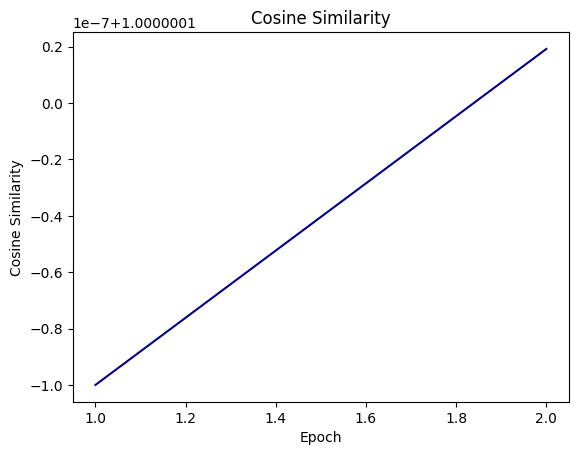

<Figure size 640x480 with 0 Axes>

In [8]:
plt.figure()  # Create a new figure
plt.plot(epoch_num, cosine_similarity, 'darkblue')
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity')
plt.show()
plt.savefig('/content/drive/MyDrive/Images/CosineSimilarity4Emotions.jpg')